[article](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

**[Anomaly detecion](https://en.wikipedia.org/wiki/Anomaly_detection)** is the process of identifying unexpected items or events in data sets, Which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection. Anomaly detection has two basic assumptions:  
- Anomalies only occur very rarely in the data.
- Their features differ from the normal instances significantly.

### Univariate Anomaly Detection
Before we get to Multivariate anomaly detection, I think its necessary to work through a simple example of Univariate anomaly detection method in which we detect outliers from a distribution of values in a single feature space.  
We are using the **Super Store Sales data set** that can be downloaded from [here](https://community.tableau.com/docs/DOC-1236), and we are going to find patterns in Sales and Profit separately that do not conform to expected behavior. That is, spotting outliers for one variable at a time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest

### Distribution of the Sales

In [2]:
df = pd.read_excel("Superstore.xls")
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

In [3]:
df.shape

(9994, 21)

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


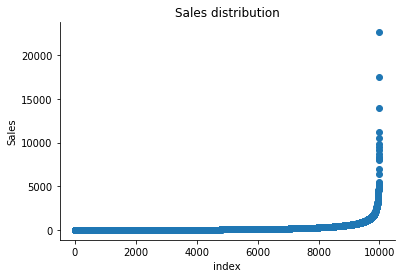

In [5]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title('Sales distribution')
sns.despine()

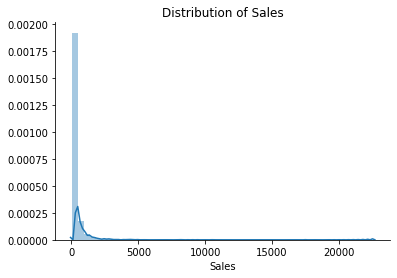

In [6]:
sns.distplot(df['Sales'])
plt.title('Distribution of Sales')
sns.despine()

In [7]:
print('Skewness: %f' % df['Sales'].skew())
print('Kurtosis: %f' % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


The Superstore's sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail sales distribution far exceeds the tails of the normal distribution.  

There are one region where the data has low probability to appear which is on the right side of the distribution.

### Distribution of the Profit

In [8]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

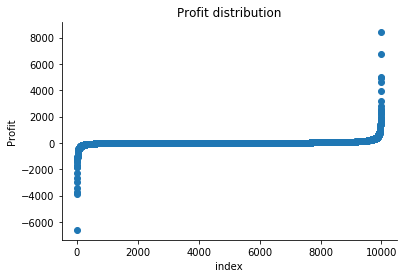

In [9]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title('Profit distribution')
sns.despine()

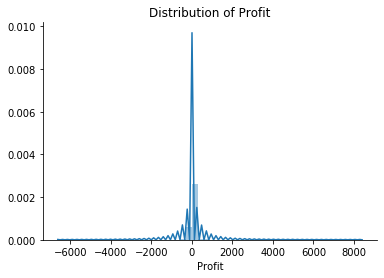

In [10]:
sns.distplot(df['Profit'])
plt.title('Distribution of Profit')
sns.despine()

In [11]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


The Superstore's Profit distribution has both a positive tail and negative tail.  
However, the positive tail is longer than the negative tail. So the distribution is positive skewed, and the data are heavy-tailed or profusion of outliers.  
There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

### Univariate Anomaly Detection on Sales
**Isolation Forest** is an algorithm to detect outliers that returns the anomaly score of each sample using the Isolation Forest algorithm which is based on the fact that anomalies are data points that are few and different. Isolation Forest is a tree-based model. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

- Trained IsolationForest using the Sales data.
- Store the Sales in the Numpy array for using in our models later.
- Computed the anomaly score for each obeservation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
- Classified each observation as an outlier or non-outlier.
- The visualization highlights the regions where the outliers fall.

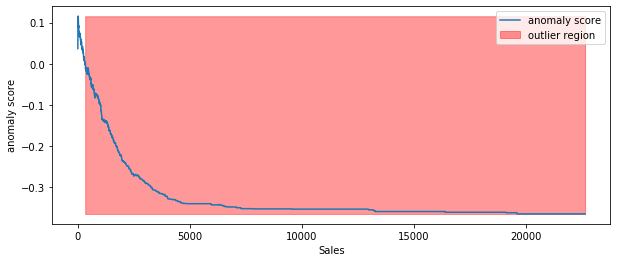

In [13]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10, 4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r', alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show()

According to the above results and visualization, It seems that Sales that exceeds 1000 would be definitely considered as an outlier.

In [15]:
df.iloc[10]

Row ID                                                 11
Order ID                                   CA-2014-115812
Order Date                            2014-06-09 00:00:00
Ship Date                             2014-06-14 00:00:00
Ship Mode                                  Standard Class
Customer ID                                      BH-11710
Customer Name                             Brosina Hoffman
Segment                                          Consumer
Country                                     United States
City                                          Los Angeles
State                                          California
Postal Code                                         90032
Region                                               West
Product ID                                FUR-TA-10001539
Category                                        Furniture
Sub-Category                                       Tables
Product Name     Chromcraft Rectangular Conference Tables
Sales         

This purchase seems normal to me expect it was a larger amount of sales compoared with the other orders in the data.

### Univariate Anomaly Detection on Profit
- Trained IsolationForest using the Profit variable.
- Store the Profit in the Numpy array for using in our models later.
- Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
- Classfied each observation as an outlier or non-outlier.
- The visualization highlights the regions where the outliers fall.

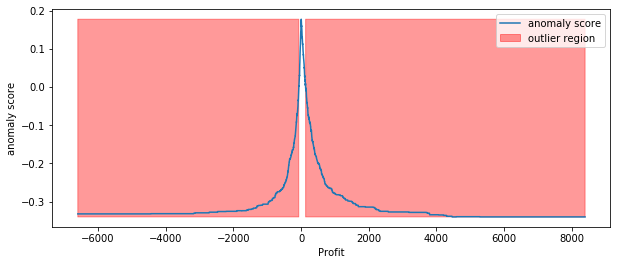

In [16]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show()

In [17]:
df.iloc[3]

Row ID                                                       4
Order ID                                        US-2015-108966
Order Date                                 2015-10-11 00:00:00
Ship Date                                  2015-10-18 00:00:00
Ship Mode                                       Standard Class
Customer ID                                           SO-20335
Customer Name                                   Sean O'Donnell
Segment                                               Consumer
Country                                          United States
City                                           Fort Lauderdale
State                                                  Florida
Postal Code                                              33311
Region                                                   South
Product ID                                     FUR-TA-10000577
Category                                             Furniture
Sub-Category                                           

### Multivariate Anomaly Detection
Most of the analysis that we end up doing are multivariate due to complexity of the wolrd we are living in. In multivariate anomaly detection, outlier is a combined unusual score on at least two variables.  
So, using the Sales and Profit variables, we are going to build an unsupervised multivariate anomaly detection method based on several models.  
we are using PyOD which is a python library for detectiong anomalies in multivariate data.

#### Sales & Profit
When we are in business, we expect that Sales & Profit are positive correlated.  
If some of the Sales data point